# Zarr SODA 3.4.2 ds

In [ ]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [ ]:
client

In [ ]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline
xr.set_options(display_style='text');

In [2]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
url_transport = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_10dy_transport_or'
#url_ice = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ice_or'

fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)
transport = xr.open_zarr(fs.get_mapper(url_transport), consolidated=True)
#ice = xr.open_zarr(fs.get_mapper(url_ice), consolidated=True)

In [ ]:
import zarr
zgroup = zarr.open_consolidated(fs.get_mapper(url_ocean))
zgroup.info

In [ ]:
zgroup.time.size

In [ ]:
zgroup.time_bounds.size

In [ ]:
time_array = zgroup.time
time_array.info

In [ ]:
dict(time_array.attrs)

In [3]:
ds = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [4]:
ds_dec = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=True)

In [ ]:
ds.time.isel(time=1893)

In [ ]:
ds.time.isel(time=1894)

In [ ]:
ds.time.isel(time=1895)

In [ ]:
#encoded time
#this index should have value of 9480
ds.time.isel(time=1896).values = 9480

In [ ]:
#this index should have value of 9485
ds.time.isel(time=1897).values = 9485

In [ ]:
ds['time'][1896] = 9480

In [ ]:
ds.time

In [ ]:
ds_dec.time

In [ ]:
xr.decode_cf(ds).time

In [5]:
#ds.time.data[-1] + 5 to get stop value
data = np.arange(0, 9850, 5)
data

array([   0,    5,   10, ..., 9835, 9840, 9845])

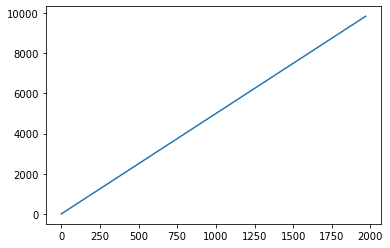

In [6]:
plt.plot(data)

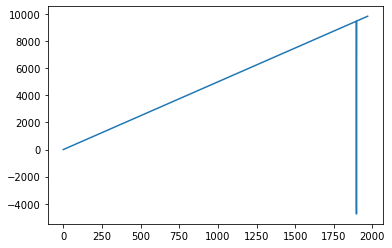

In [7]:
plt.plot(ds.time.data)

In [8]:
ds.time.data

array([   0,    5,   10, ..., 9835, 9840, 9845])

In [9]:
data

array([   0,    5,   10, ..., 9835, 9840, 9845])

In [10]:
ds.time

<xarray.DataArray 'time' (time: 1970)>
array([   0,    5,   10, ..., 9835, 9840, 9845])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845
Attributes:
    bounds:          time_bounds
    calendar:        julian
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time
    units:           days since 1993-01-04 13:00:00.000000

### Mark 1

In [11]:
time_data_test = xr.DataArray(data=data, dims=['time'], coords=dict(time=('time',data)))

In [12]:
time_data_ds = time_data_test.to_dataset(name='time_new')

In [13]:
time_data_ds

<xarray.Dataset>
Dimensions:   (time: 1970)
Coordinates:
  * time      (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845
Data variables:
    time_new  (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845

In [14]:
xr.decode_cf(time_data_ds).time_new

<xarray.DataArray 'time_new' (time: 1970)>
array([   0,    5,   10, ..., 9835, 9840, 9845])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845

In [15]:
xr.decode_cf(time_data_ds).time

<xarray.DataArray 'time' (time: 1970)>
array([   0,    5,   10, ..., 9835, 9840, 9845])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845

### Mark 2

In [16]:
ds.time

<xarray.DataArray 'time' (time: 1970)>
array([   0,    5,   10, ..., 9835, 9840, 9845])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845
Attributes:
    bounds:          time_bounds
    calendar:        julian
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time
    units:           days since 1993-01-04 13:00:00.000000

In [17]:
ds_dec.time

<xarray.DataArray 'time' (time: 1970)>
array([cftime.DatetimeJulian(1993, 1, 4, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [18]:
time_copy = ds.time.copy(deep=False)
time_coord = time_copy.coords.to_dataset().reset_coords() 
#^separating time coord to be a ds itself so that can change values of it in next line but keep encoded time info
time_coord_copy = time_coord.time.copy(data=data) 
#^rewriting the coord data for self-created data
time_new_data_coord = time_copy.assign_coords(time=time_coord_copy) 
#^assigning new values for coord to copied time array

In [ ]:
time_coord

In [19]:
time_new_data_coord

<xarray.DataArray 'time' (time: 1970)>
array([   0,    5,   10, ..., 9835, 9840, 9845])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845
Attributes:
    bounds:          time_bounds
    calendar:        julian
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time
    units:           days since 1993-01-04 13:00:00.000000

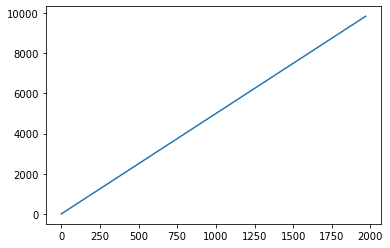

In [20]:
plt.plot(time_new_data_coord.time.values)

In [21]:
time_new = time_new_data_coord.to_dataset(name = 'time_new')

In [22]:
time_new

<xarray.Dataset>
Dimensions:   (time: 1970)
Coordinates:
  * time      (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845
Data variables:
    time_new  (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845

In [23]:
time_new_dec = xr.decode_cf(time_new, decode_coords=True).time_new

In [24]:
time_new_dec

<xarray.DataArray 'time_new' (time: 1970)>
array([cftime.DatetimeJulian(1993, 1, 4, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [25]:
ds_dec.time

<xarray.DataArray 'time' (time: 1970)>
array([cftime.DatetimeJulian(1993, 1, 4, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [26]:
ds.time

<xarray.DataArray 'time' (time: 1970)>
array([   0,    5,   10, ..., 9835, 9840, 9845])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 ... 9820 9825 9830 9835 9840 9845
Attributes:
    bounds:          time_bounds
    calendar:        julian
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time
    units:           days since 1993-01-04 13:00:00.000000

In [85]:
time_new_dec

<xarray.DataArray 'time_new' (time: 1970)>
array([cftime.DatetimeJulian(1993, 1, 4, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

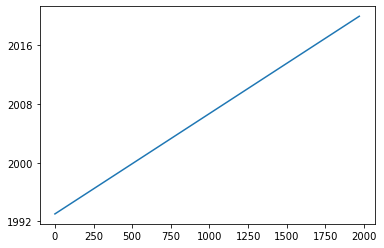

In [80]:
plt.plot(time_new_dec.time.data)

### Add `Mark 2`'s time obj to original ds

In [182]:
ds_new = ds.drop_vars('time').assign_coords({'time': ('time', time_new_dec.time.values)})

In [183]:
ds_new

<xarray.Dataset>
Dimensions:          (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 1970, xt_ocean: 1440, xu_ocean: 1440, yt_ocean: 1070, yu_ocean: 1070)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * st_edges_ocean   (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean         (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * xt_ocean         (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.62 79.88
  * xu_ocean         (xu_ocean) float64 -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yt_ocean         (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.84 89.95
  * yu_ocean         (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.89 90.0
  * time             (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
Data variables:
    anompb           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    average_DT       (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    evap_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hflux_cpl        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hflux_pme        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hflux_total      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    lw_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mlp              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mls              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mlt              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    net_heating      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    prho             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    salt             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    salt_flux_rstr   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    salt_flux_total  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    sbd              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    sbd_dhdt         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    sbd_horz         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    sbd_mld          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    sbd_vert         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    sens_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ssh              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    swflx            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    taux             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    tauy             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<ch

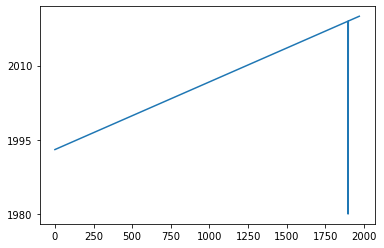

In [186]:
plt.plot(time_new_dec.values)

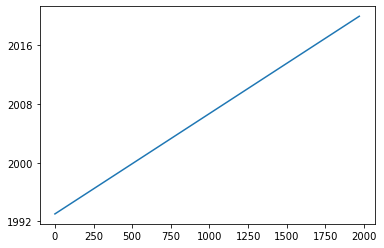

In [187]:
plt.plot(ds_new.time.values)

In [188]:
ds_new.time

<xarray.DataArray 'time' (time: 1970)>
array([cftime.DatetimeJulian(1993, 1, 4, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 13, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 12, 9, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 13, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 19, 13, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

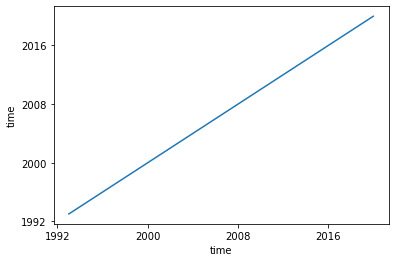

In [189]:
ds_new.time.plot()

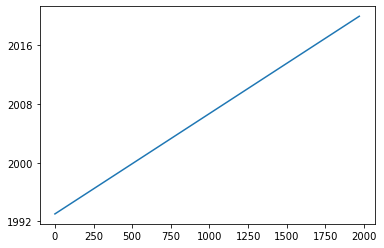

In [192]:
plt.plot(ds_new.time.data)

In [194]:
ds_new.time[1897]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeJulian(2018, 12, 24, 13, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2018-12-24 13:00:00

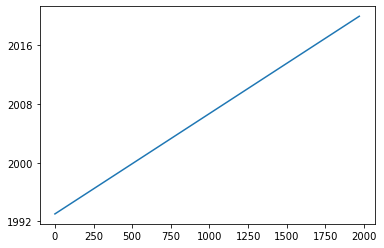

In [130]:
plt.plot(time_new_dec.time.data)

In [200]:
ds.time[1896]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeJulian(1980, 1, 1, 13, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1980-01-01 13:00:00

In [201]:
ds.time[1897]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeJulian(1980, 1, 1, 13, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1980-01-01 13:00:00

(array([11066508., 11728264.,  3324410.,  2609242.,  2211332.,  1679436.,
         1420327.,  1141572.,  1078128.,   209248.]),
 array([-2.2516625,  1.2208495,  4.6933613,  8.165874 , 11.638386 ,
        15.110897 , 18.58341  , 22.055922 , 25.528433 , 29.000946 ,
        32.473457 ], dtype=float32),
 <BarContainer object of 10 artists>)

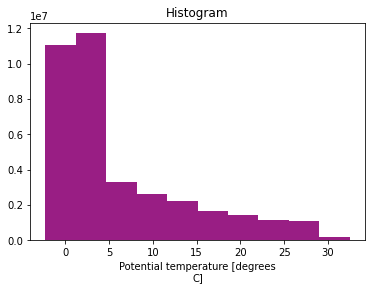

In [213]:
#vars in old ds and new ds time match
ds.temp[1896].plot(color='red', alpha=0.8)
ds_new.temp[1896].plot(color='blue', alpha=0.4)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

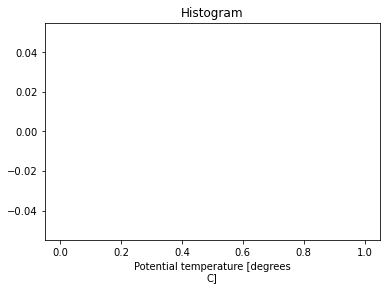

In [214]:
#vars in old ds and new ds time match
ds.temp[1897].plot(color='red', alpha=0.8)
ds_new.temp[1897].plot(color='blue', alpha=0.4)

In [ ]:
import xgcm

grid_ocean = xgcm.Grid(ocean, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean

In [ ]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

## Variables to create:

- [ ] Vel terms for psi
- [ ] Surf flux term (incl. sw penetration)
- [ ] Total tendency term

## <font color='Green'>Get cell area and volume in meters</font>

In [ ]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

In [ ]:
#converting lat from degrees to meters
delta_lat = grid_ocean.diff(ocean.yt_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_u = grid_ocean.diff(ocean.yu_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ocean.diff(ocean.xt_ocean, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ocean.yt_ocean))
delta_lon_u = grid_ocean.diff(ocean.xu_ocean, 'X', boundary_discontinuity=360)
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(ocean.yu_ocean))

In [ ]:
dx

In [ ]:
dx_u

In [ ]:
dx.plot()

In [ ]:
dz = grid_ocean.diff(ocean.st_edges_ocean[1:], 'Z', boundary='fill', fill_value=0.)
dz_u = grid_ocean.diff(ocean.sw_edges_ocean[1:], 'Zu', boundary='fill', fill_value=0.)

In [ ]:
cell_elements = xr.merge([dx.rename('dx'), dx_u.rename('dx_u'), 
                          dy.rename('dy'), dy_u.rename('dy_u'), 
                          dz.rename('dz'), dz_u.rename('dz_u')])

In [ ]:
cell_elements

## <font color='Green'>Slice to WG region</font>

In [ ]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [ ]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [ ]:
ocean_wg = ocean.isel(**lat_range, **lon_range)
transport_wg = transport.isel(**lat_range, **lon_range)
cells_wg = cell_elements.isel(**lat_range, **lon_range)

In [ ]:
import xgcm

grid_ocean_wg = xgcm.Grid(ocean_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean_wg

In [ ]:
transport.tx_int[0].plot()

In [ ]:
transport_wg.tx_int[0].plot()

## <font color='Green'>\begin{equation*} Transport/Vel\ terms \end{equation*}</font>

In [ ]:
transport_wg.tx_trans.isel(xu_ocean=-1)

In [ ]:
cells_wg.dz.coords

In [ ]:
cells_wg.dy_u.coords

In [ ]:
transport_wg.ty_trans.coords

In [ ]:
cells_wg.dx_u.coords

In [ ]:
u_transport_right = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=-1)
u_transport_left = (transport_wg.tx_trans * cells_wg.dz * cells_wg.dy_u).isel(xu_ocean=0)

v_transport = (transport_wg.ty_trans * cells_wg.dz * cells_wg.dx_u).isel(yu_ocean=-1)

In [ ]:
ocean_wg.wt[0].coords

In [ ]:
cells_wg.dy_u.coords

In [ ]:
dx_interp = grid_ocean_wg.interp(cells_wg.dx_u, 'Y', boundary='fill')

In [ ]:
dx_interp.coords

In [ ]:
w_transport = (ocean_wg.wt * dx_interp * cells_wg.dy_u).isel(sw_ocean=0)

In [ ]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho

#surf_transport = (ocean_wg.net_heating * dx_interp * cells_wg.dy_u) / (heat_capacity_cp * runit2mass)
surf_transport = ocean_wg.net_heating  / (heat_capacity_cp * runit2mass)

In [ ]:
u_transport_left[0]

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [ ]:
client

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left.mean(dim='time')/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary\n time mean')
(u_transport_right.mean(dim='time')/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport.mean(dim='time')/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [ ]:
client.restart()

In [ ]:
u_transport_right

In [ ]:
u_transport_left

In [ ]:
v_transport

In [ ]:
w_transport

In [ ]:
surf_transport

In [ ]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')/1e6
u_transport_mean_value.load()

In [ ]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')/1e6
v_transport_mean_value.load()

In [ ]:
w_transport_mean_value = (w_transport).fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')/1e6
w_transport_mean_value.load()

In [ ]:
surf_transport_mean_value = surf_transport.fillna(0.).sum(dim=['xt_ocean', 'yt_ocean']).mean(dim='time')
surf_transport_mean_value.load()

In [ ]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
residual

## <font color='Green'>\begin{equation*} Surface\ Fluxes \end{equation*}</font>

In [ ]:
ocean_wg.salt_flux_total

In [ ]:
ocean_wg.hflux_total

In [ ]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = (ocean_wg.hflux_total * dx_interp * dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s
surf_flux_slt = (ocean_wg.salt_flux_total * dx_interp * dy_u) / runit2mass # psu*m^3/s

In [ ]:
surf_flux_th

In [ ]:
surf_flux_slt

In [ ]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ocean_wg.hflux_total[0].plot(ax=ax0)
ocean_wg.salt_flux_total[0].plot(ax=ax1)
plt.tight_layout();

In [ ]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th[0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt[0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Surface fluxes at timestep 0', fontweight='bold')
plt.tight_layout();

In [ ]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

In [ ]:
ocean_wg.temp

In [ ]:
def surface_to_3d(da):
    da = da.copy()
    da.coords['st_ocean'] = ocean_wg.st_ocean[0]
    da = da.expand_dims(dim='st_ocean', axis=1)
    da, _ = xr.align(da, ocean_wg.st_ocean, join='right')
    return da.fillna(0.)

In [ ]:
surf_flux_th

In [ ]:
surf_flux_conv_TH = surface_to_3d(surf_flux_th)
surf_flux_conv_SLT = surface_to_3d(surf_flux_slt)

## SW flux penetration

In [ ]:
ocean_wg.swflx

In [ ]:
#sw flux
sw_flux = (ocean_wg.swflx * dx_interp * dy_u) / (heat_capacity_cp * runit2mass) #˚C*m^3/s

### ^ Need to figure out how to treat swflx penetrating through cell levels
__(PG 252 in MOM5 manual)__

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>

In [ ]:
#creating new time dim-coord by dropping 1980-01-01 13:00:00 from indices 1896 & 1897
#time is also missing 14th and 19th day for 2018 and 2019
ocean_wg.coords['time_no1980'] = ocean_wg.time.where(ocean_wg.time != ocean_wg.time.isel(time=1896), drop=True)
ocean_wg['time_no1980'] = ocean_wg.time.where(ocean_wg.time != ocean_wg.time.isel(time=1896), drop=True).values

In [ ]:
ocean_wg.time.where(ocean_wg.time != ocean_wg.time.isel(time=1896), drop=True)

In [ ]:
xr.decode_cf(ocean_wg.isel(time=1896)[['time']]).time

In [ ]:
ocean_wg.time

In [ ]:
ocean_wg.time.plot()

In [ ]:
ocean_wg.time.sel(time='2019')

In [ ]:
ocean_wg.time.sel(time=slice('1993', '2019'), method='nearest')

In [ ]:
plt.plot(ocean_wg.time.values)

In [ ]:
ocean_wg.time_no1980

In [ ]:
dt_values = (ocean_wg.time_no1980.diff('time_no1980') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time_no1980'], 
                  coords={'time_no1980': (['time_no1980'], ocean_wg.time_no1980.values[1:])}) #shaves off first time stamp in `ocean_wg.time_no1980`
ocean_wg.coords['dt'] = dt

In [ ]:
ocean_wg.time_no1980[0:5].plot(color='r', marker='.')
dt_values.time_no1980[0:5].plot(color='k', linestyle='dashed')

In [ ]:
ocean_wg.time_no1980[-5:].plot(color='r', marker='.')
dt_values.time_no1980[-5:].plot(color='k', linestyle='dashed')

**Theta Tendency Term**

In [ ]:
ocean_wg.temp

In [ ]:
ocean_wg.temp[1896][0].plot()

In [ ]:
ocean_wg.temp[1897][0].plot()

In [ ]:
ocean_wg.time[1896]

In [ ]:
ocean_wg.temp.time

In [ ]:
#create new temp var w/ no 1980
temp = ocean_wg.temp.where(ocean_wg.temp.time != ocean_wg.time.isel(time=1896), drop=True)

In [ ]:
client

In [ ]:
temp[0,0].plot()

In [ ]:
delta_theta = temp.diff('time')#.load()

In [ ]:
delta_theta.time.plot()
ocean_wg.dt[1:].plot()

In [ ]:
ocean_wg.dt[1:]

In [ ]:
ocean_wg.dt.time_no1980[1:]

In [ ]:
delta_theta

In [ ]:
theta_tend = (delta_theta / ocean_wg.dt[1:])#.load()

In [ ]:
theta_tend

In [ ]:
ocean_wg.swflx

In [ ]:
theta_tend[0,0].plot()

In [ ]:
client

In [ ]:
theta_tend.coords#[:,1:,1:,1:]

In [ ]:
dx_u_wg_interp.coords

In [ ]:
dy_u_wg.coords

In [ ]:
dz.coords

In [ ]:
totttend = theta_tend * dx_u_wg_interp * dy_u_wg * dz

In [ ]:
(totttend[0,0]/1e6).plot()

**Salt Tendency Term**

In [ ]:
delta_salt = salt.diff('time')

In [ ]:
#forcing delta_salt to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','level','lat','lon'], 
                            coords={'time': coords_wg.dt[0:-1].time.data,
                                    'level': coords_wg.level,
                                    'lat': coords_wg.lat,
                                    'lon': coords_wg.lon})
delta_salt

In [ ]:
salt_tend = (delta_salt / coords.dt[0:-1])

In [ ]:
salt_tend[0,0].plot()

In [ ]:
salt_tend.coords

In [ ]:
totstend = salt_tend * dx_u_wg_interp * dy_u_wg * dz

In [ ]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(totstend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

In [ ]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend.isel(time=slice(0,-1), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(totstend.isel(time=slice(0,-1), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

In [ ]:
((temp[-3,0, 1:, 1:] - temp[0,0, 1:, 1:])/1e6).plot(cmap='RdBu_r', vmax=0)#, vmin=-6e-5)

In [ ]:
(temp[-3, 0] - temp[0, 0]).plot()